In [2]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn

!pip install git+https://github.com/gretelai/gretel-synthetics.git

In [3]:
!pip install gretel-synthetics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 3.9 MB/s eta 0:00:00
  Using cached category_encoders-2.2.2-py2.py3-none-any.whl (80 kB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gretel-synthetics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.8/140.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.8/124.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sn

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType



In [5]:
# Read smart home sensor data from https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
sensor_df = pd.read_csv("/content/pca_data.csv")
sensor_df["datetime"] = pd.to_datetime(sensor_df["date_l"])
sensor_df

<ipython-input-5-dc51c35e7337>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sensor_df["datetime"] = pd.to_datetime(sensor_df["date_l"])


,date_l,0,1,2,3,4,5,6,7,8,9,sleep_score,datetime
0,01-11-2019,413738.02950,-303.036273,-202.875725,7.241108,-35.355549,-5.632281,-0.542155,-28.325709,15.539929,-10.868174,76.000000,2019-01-11
1,02-11-2019,29788.32456,-133.149038,-130.322905,14.760154,1.561312,-17.069592,-16.785398,-47.324371,23.013005,-5.826709,79.000000,2019-02-11
2,03-11-2019,117401.57000,-290.083215,-38.491289,8.540125,36.530798,22.816158,19.911579,-31.574069,26.278557,-2.271233,71.000000,2019-03-11
3,04-11-2019,-142735.11890,-47.595466,-52.888556,0.411640,-46.579658,-7.553320,-21.787858,-3.642655,19.625040,-4.396101,68.000000,2019-04-11
4,05-11-2019,342792.69260,543.043192,-245.583383,-9.739468,-131.799056,59.574483,-75.935846,16.805582,0.783841,-7.883455,73.000000,2019-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,27-03-2020,-106580.99830,-165.654766,-101.884764,-88.426201,-103.884912,-70.996962,6.866186,8.436936,-12.683985,22.090879,72.000000,2020-03-27
148,28-03-2020,297789.33660,-261.048794,-96.280021,-45.682472,8.734015,-55.186305,57.827117,-28.558441,23.034349,-32.719721,67.000000,2020-03-28
149,29-03-2020,-487655.94870,115.631448,-92.516842,25.178448,-3.992929,-36.431421,-29.376785,-33.084799,4.032717,7.126723,62.000000,2020-03-29
150,30-03-2020,-644499.93140,176.484606,9.111618,43.585015,-50.157852,-35.881840,27.137623,-11.798140,-0.539791,-13.881158,78.000000,2020-03-30


In [6]:
# Use 4 temperature columns for this example
COLUMNS = ["0", "1", "2",'3','4','5','6','7','8','9', "sleep_score"]

train_df = sensor_df[["datetime"] + COLUMNS]
train_df

,datetime,0,1,2,3,4,5,6,7,8,9,sleep_score
0,2019-01-11,413738.02950,-303.036273,-202.875725,7.241108,-35.355549,-5.632281,-0.542155,-28.325709,15.539929,-10.868174,76.000000
1,2019-02-11,29788.32456,-133.149038,-130.322905,14.760154,1.561312,-17.069592,-16.785398,-47.324371,23.013005,-5.826709,79.000000
2,2019-03-11,117401.57000,-290.083215,-38.491289,8.540125,36.530798,22.816158,19.911579,-31.574069,26.278557,-2.271233,71.000000
3,2019-04-11,-142735.11890,-47.595466,-52.888556,0.411640,-46.579658,-7.553320,-21.787858,-3.642655,19.625040,-4.396101,68.000000
4,2019-05-11,342792.69260,543.043192,-245.583383,-9.739468,-131.799056,59.574483,-75.935846,16.805582,0.783841,-7.883455,73.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
147,2020-03-27,-106580.99830,-165.654766,-101.884764,-88.426201,-103.884912,-70.996962,6.866186,8.436936,-12.683985,22.090879,72.000000
148,2020-03-28,297789.33660,-261.048794,-96.280021,-45.682472,8.734015,-55.186305,57.827117,-28.558441,23.034349,-32.719721,67.000000
149,2020-03-29,-487655.94870,115.631448,-92.516842,25.178448,-3.992929,-36.431421,-29.376785,-33.084799,4.032717,7.126723,62.000000
150,2020-03-30,-644499.93140,176.484606,9.111618,43.585015,-50.157852,-35.881840,27.137623,-11.798140,-0.539791,-13.881158,78.000000


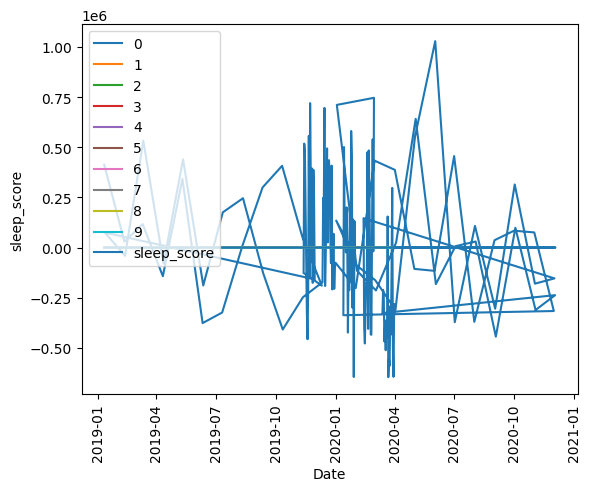

In [7]:
# Plot the 4 columns over the 4+ months of data
for c in COLUMNS:
    plt.plot(train_df["datetime"], train_df[c], label=c)
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("sleep_score")
plt.xlabel("Date")
plt.show()

In [8]:
import numpy as np


features = train_df.drop(columns="datetime").to_numpy()


n_examples = features.shape[0]
n_features = features.shape[1]

# Reshape the data
features = features.reshape(n_examples, 1, n_features)

# Now, features will have the shape (# examples, 1, # features)
print(features.shape)


(152, 1, 11)


In [9]:
# Recommended to train with a GPU
torch.cuda.is_available()

True

In [21]:
%%capture

# Train DGAN model
model = DGAN(DGANConfig(
    max_sequence_len=features.shape[1],
    sample_len=1,
    batch_size=min(1000, features.shape[0]),
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=1000,
))

model.train_numpy(
    features,
    feature_types=[OutputType.CONTINUOUS] * features.shape[2],
)
num_input = int(input("Enter no. of rows to generate "))
# Generate synthetic data
_, synthetic_features = model.generate_numpy(num_input)



Enter no. of rows to generate 10000


In [22]:
synthetic_features

array([[[ 2.93520938e+05,  1.06459473e+02,  1.14361053e+02, ...,
          7.49655533e+00, -8.29204178e+00,  6.76451187e+01]],

       [[ 9.53205000e+04, -2.65709717e+02, -3.95073547e+01, ...,
         -1.76544304e+01, -1.03132744e+01,  7.17007065e+01]],

       [[ 2.11977062e+05, -3.83642487e+02, -2.53970947e+02, ...,
         -2.98229961e+01,  3.98122025e+00,  7.94101639e+01]],

       ...,

       [[ 1.12186625e+05,  1.65619507e+02,  1.00606842e+02, ...,
          1.25772057e+01, -3.61632156e+00,  6.88586349e+01]],

       [[ 9.89488125e+04, -3.51352966e+02, -6.50689697e+00, ...,
         -1.97329330e+00, -2.26908798e+01,  6.33068161e+01]],

       [[ 5.72077250e+05,  2.00666809e+02,  1.34369171e+02, ...,
          1.18319130e+01, -1.61171188e+01,  7.32835541e+01]]],
      dtype=float32)

In [23]:
# Compare (non-temporal) correlations between the 4 temperatures
synthetic_df = pd.DataFrame(synthetic_features.reshape(-1, synthetic_features.shape[2]), columns=train_df.columns[1:])

print("Correlation in real data:")
print(train_df.corr())
print()
print("Correlation in synthetic data:")
print(synthetic_df.corr())

# Correlations between temperature variables are similar

Correlation in real data:
                        0             1             2             3  \
0            1.000000e+00 -1.070340e-11  8.905747e-12  1.987595e-11   
1           -1.070340e-11  1.000000e+00  4.844314e-12  1.449619e-11   
2            8.905747e-12  4.844314e-12  1.000000e+00  8.410291e-12   
3            1.987595e-11  1.449619e-11  8.410291e-12  1.000000e+00   
4           -8.882308e-12  4.625507e-12 -1.361044e-11  1.448497e-11   
5            1.061883e-11 -7.752287e-13 -1.564159e-11  1.148100e-12   
6            6.411701e-12  1.901611e-11 -7.058470e-12  8.731794e-12   
7           -3.160321e-12  2.325597e-12  2.023761e-13  1.954450e-11   
8           -1.232148e-11  6.834705e-12 -2.781317e-11  2.691975e-11   
9           -1.432568e-11  5.248800e-12 -7.372889e-12 -1.987330e-11   
sleep_score  7.982772e-03 -3.773870e-02 -1.313407e-01  4.906532e-01   

                        4             5             6             7  \
0           -8.882308e-12  1.061883e-11  6.411701e

<ipython-input-23-00ff9e06563e>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(train_df.corr())


In [24]:
synthetic_df

,0,1,2,3,4,5,6,7,8,9,sleep_score
0,293520.9375,106.459473,114.361053,-31.452972,108.204224,57.688217,35.499168,5.196869,7.496555,-8.292042,67.645119
1,95320.5000,-265.709717,-39.507355,-56.099335,-11.707565,-26.713409,-21.947052,-23.835747,-17.654430,-10.313274,71.700706
2,211977.0625,-383.642487,-253.970947,8.503235,-59.061211,-147.460022,-49.382221,-55.497131,-29.822996,3.981220,79.410164
3,-246784.2500,252.587280,47.084747,118.398590,25.655212,-55.165787,13.054680,34.691666,13.105007,7.276310,73.406006
4,196564.7500,-293.729095,-69.824493,-196.955658,39.341232,97.154953,-7.104866,-49.644279,-15.009758,-15.058067,66.307549
...,...,...,...,...,...,...,...,...,...,...,...
9995,3644.1875,251.267090,-88.126190,211.080475,2.988022,-147.334351,8.405975,27.935562,-0.718193,20.250977,79.433022
9996,-141733.1875,-76.281982,-105.687927,-180.645844,46.682022,24.179718,-1.908905,-55.141308,-17.721592,7.406330,69.626907
9997,112186.6250,165.619507,100.606842,8.562378,83.063400,32.205078,32.439583,17.616638,12.577206,-3.616322,68.858635
9998,98948.8125,-351.352966,-6.506897,-191.324768,10.683716,117.802048,-23.771561,-35.484734,-1.973293,-22.690880,63.306816


In [25]:


# Assuming you have a DataFrame called 'df'
synthetic_df.to_csv('data.csv', index=False)

<ipython-input-26-f523f8d932b6>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(sensor_df.corr(), fignum=f.number)


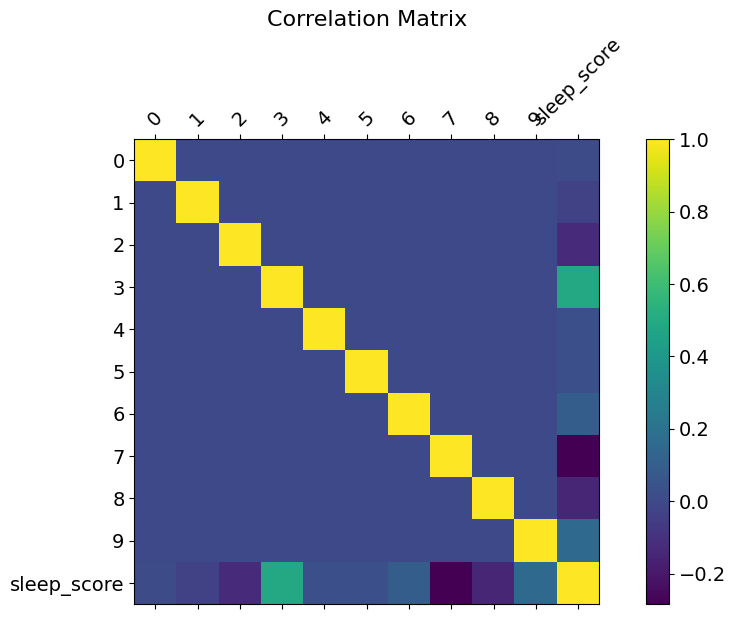

In [26]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
plt.matshow(sensor_df.corr(), fignum=f.number)
plt.xticks(range(sensor_df.select_dtypes(['number']).shape[1]), sensor_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(sensor_df.select_dtypes(['number']).shape[1]), sensor_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

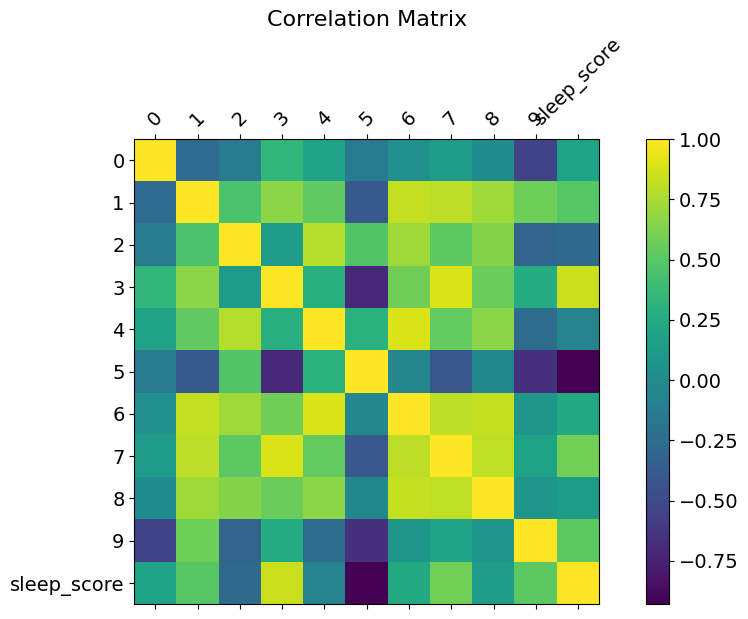

In [27]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
plt.matshow(synthetic_df.corr(), fignum=f.number)
plt.xticks(range(synthetic_df.select_dtypes(['number']).shape[1]), synthetic_df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(synthetic_df.select_dtypes(['number']).shape[1]), synthetic_df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

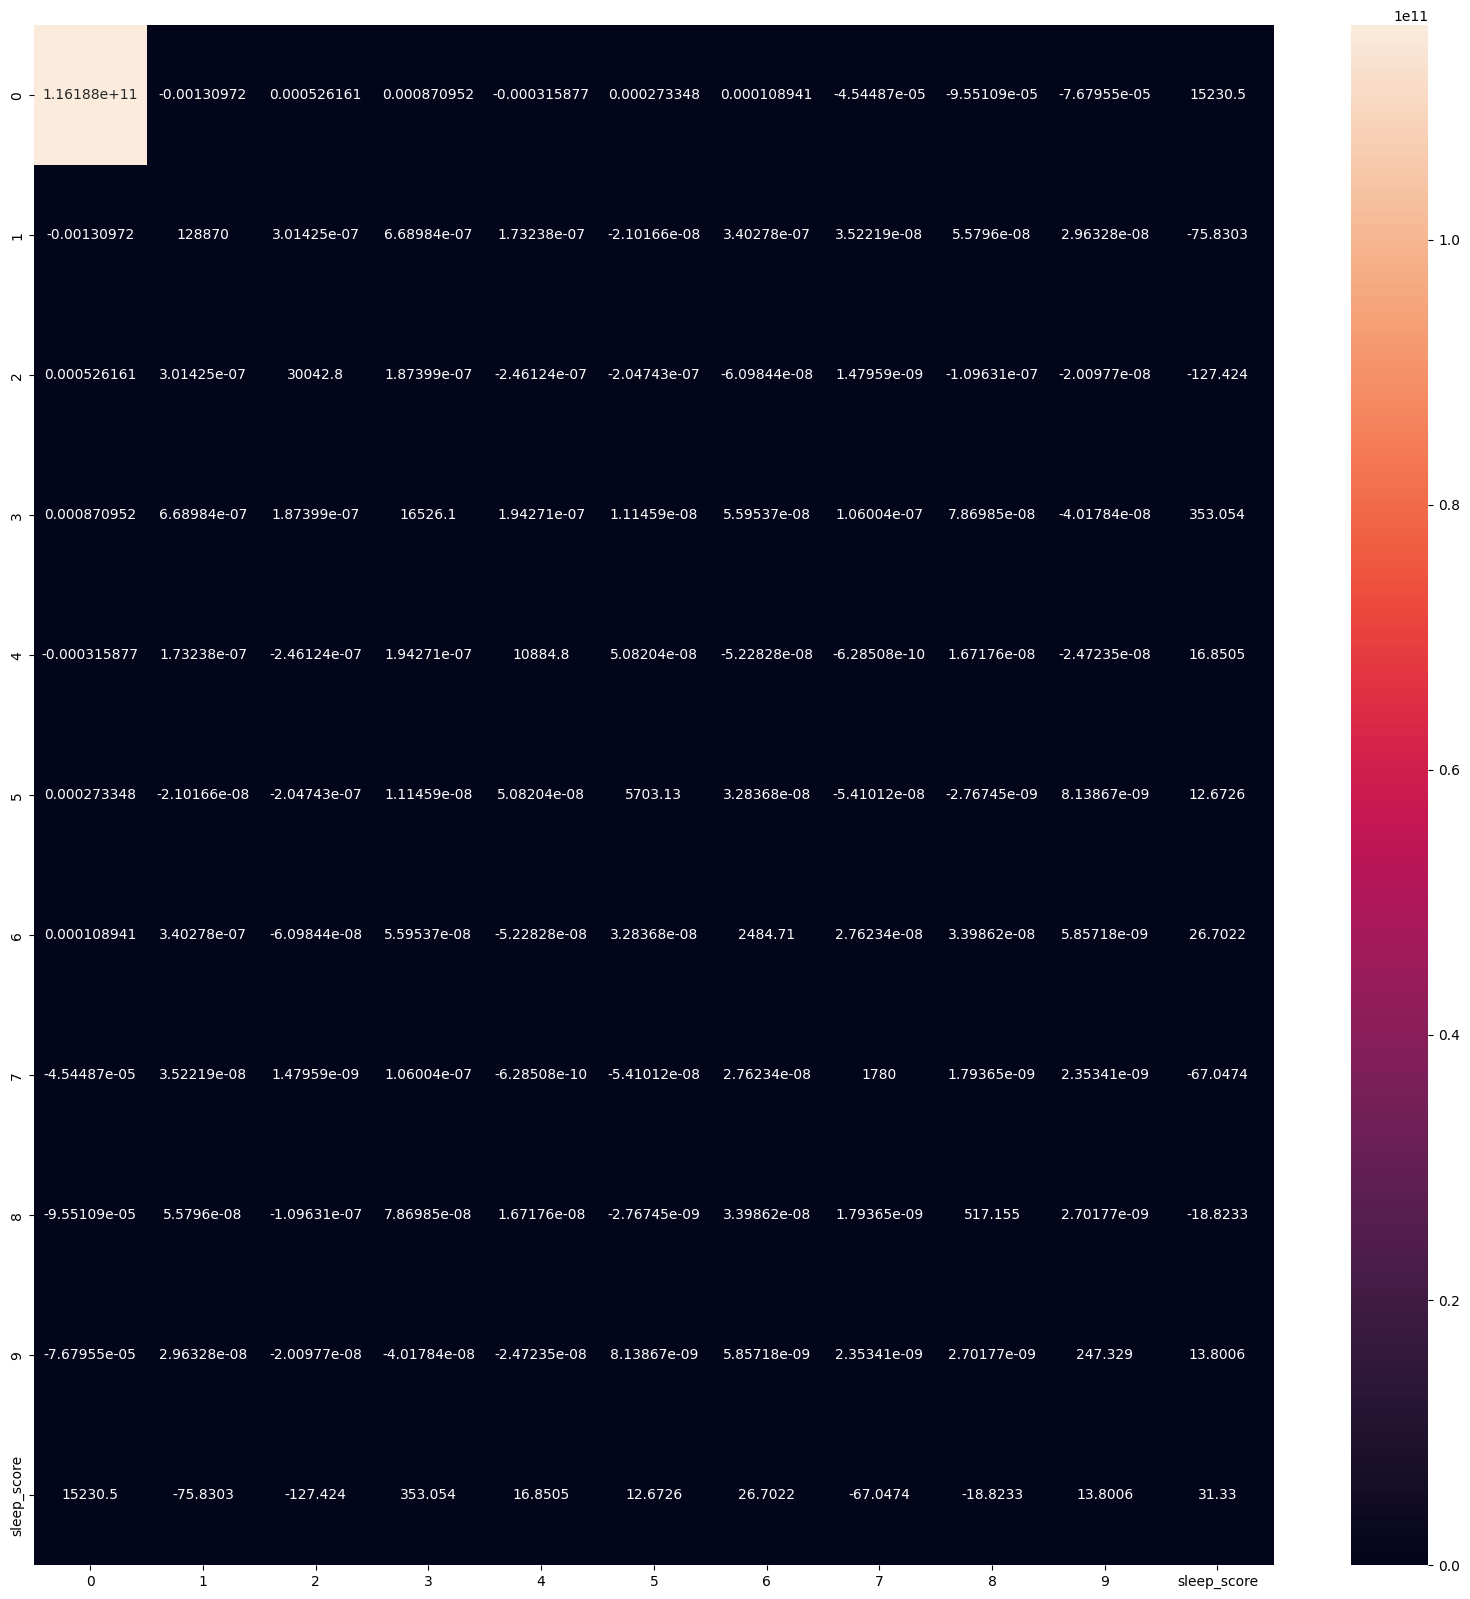

In [28]:
df1 = train_df.drop(['datetime'],axis=1)
cov_matrix = pd.DataFrame.cov(df1)
plt.figure(figsize=(20,20))
sn.heatmap(cov_matrix, annot=True, fmt='g')
plt.show()

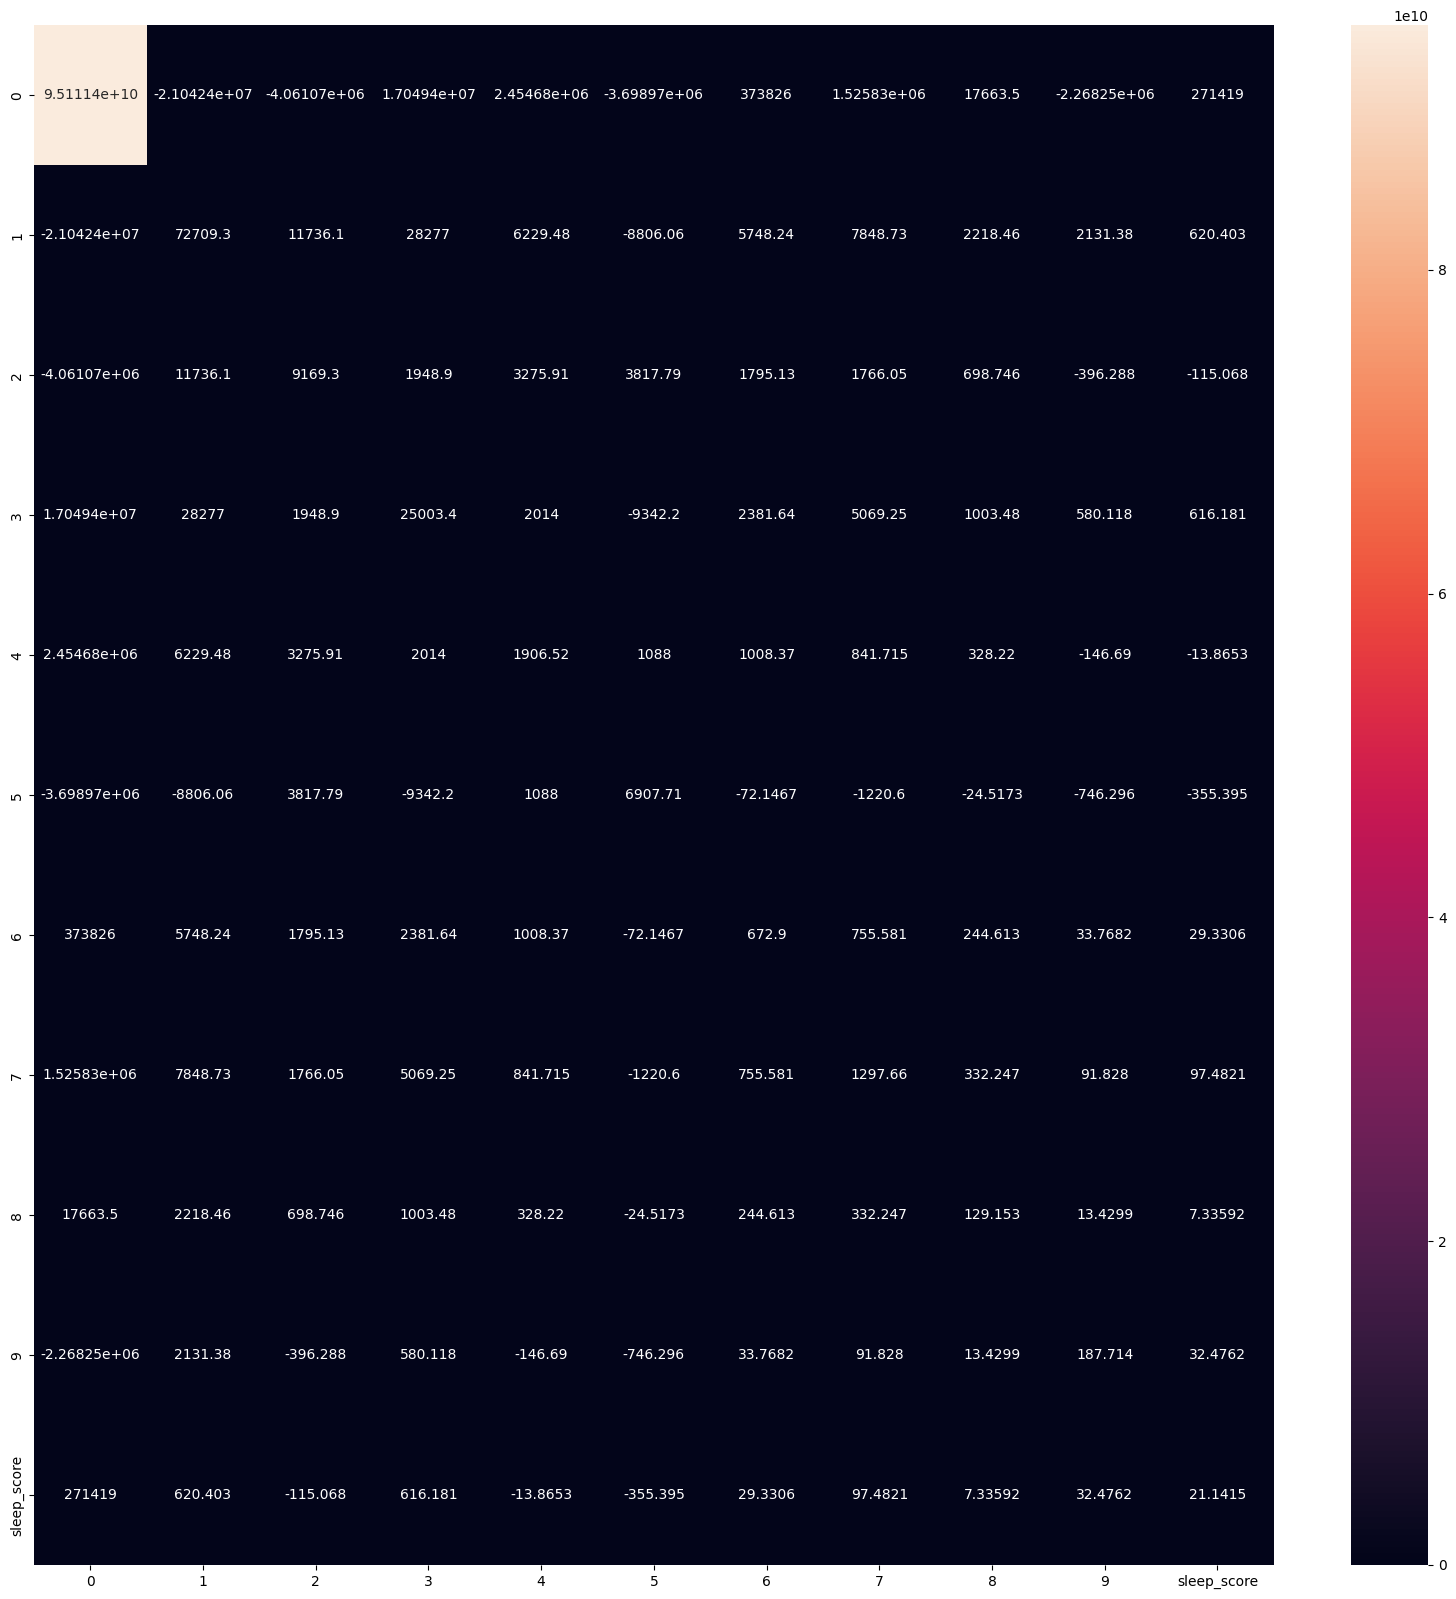

In [29]:
cov_matrix = pd.DataFrame.cov(synthetic_df)
plt.figure(figsize=(20,20))
sn.heatmap(cov_matrix, annot=True, fmt='g')
plt.show()